In [1]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Thu OCt 19 15:55:00 2017

@author: ncaplar

When preparing this notebook I used a number of jupyer extensions:
https://github.com/ipython-contrib/jupyter_contrib_nbextensions
https://github.com/Jupyter-contrib/jupyter_nbextensions_configurator

"""
%connect_info

{
  "stdin_port": 58361, 
  "ip": "127.0.0.1", 
  "control_port": 58362, 
  "hb_port": 58363, 
  "signature_scheme": "hmac-sha256", 
  "key": "9da810dc-bf619eb472a8dc2eefc98012", 
  "kernel_name": "", 
  "shell_port": 58359, 
  "transport": "tcp", 
  "iopub_port": 58360
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-7d02a9b3-fd42-470d-83d0-9336fd8e341c.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


# Damping for Main Sequence?

In [1]:
import numpy as np
import astroML
import socket
import os
import datetime
np.set_printoptions(suppress=True)
import pandas as pd
import scipy

# If you do not have DELCgen go to https://github.com/samconnolly/DELightcurveSimulation
from DELCgen import *

from matplotlib import pyplot as plt
from itertools import repeat
from astroML.time_series import\
    lomb_scargle, lomb_scargle_BIC, lomb_scargle_bootstrap
from astroML.time_series import \
    generate_power_law

%matplotlib inline

print('Current workstation: '+str(socket.gethostname()))
print('Current time: '+str(datetime.datetime.now())) 

cwd = os.getcwd()
base_dir=cwd+'/MSData'
if not (os.path.exists(base_dir) | (cwd[-6:]=='MSData')):
    os.makedirs(base_dir)
    os.chdir(base_dir)
else:    
    os.chdir(cwd)
os.chdir(base_dir)
print('Working directory is:'+str(base_dir))    
  

Current workstation: IapetusUSA
Current time: 2017-10-21 20:47:19.751561
Working directory is:/Users/nevencaplar/Documents/Variability/MainSequence/MSData


In [115]:
# I do not think I ever use this, but lets keep it for fun
def compute_sf_log(ligth_curve_sort_and_clean):
    array_of_magnitude_differences = [];
    for n in range(len(ligth_curve_sort_and_clean)-1):
        array_of_magnitude_differences.append(ligth_curve_sort_and_clean[n]-ligth_curve_sort_and_clean[n+1:])
    array_of_magnitude_differences=np.vstack(array_of_magnitude_differences)
    array_of_magnitude_differences[:,0]=array_of_magnitude_differences[:,0]*(-1)
    Structure_Function_Log_Bins = [];
    Array_Of_Log_Limits=np.percentile(np.log10(array_of_magnitude_differences[:,0]),range(0,50,1))
    for n in range(1,len(Array_Of_Log_Limits)-1):
        single_bin=array_of_magnitude_differences[((Array_Of_Log_Limits[n])<=(np.log10(array_of_magnitude_differences[:,0])))&((np.log10(array_of_magnitude_differences[:,0]))<=Array_Of_Log_Limits[n+1])]   
        Structure_Function_Log_Bins.append([np.mean(single_bin[:,0]),np.var(single_bin[:,1])])
    Structure_Function_Log_Bins5=np.vstack(Structure_Function_Log_Bins)
    return Structure_Function_Log_Bins5

## Small simple example - Sandro, you can ignore this

In [5]:
N=100+4*365+1
y=0.42*astroML.time_series.generate_power_law(N,dt=1,beta=2)

In [6]:
ligth_curve_sort_and_clean=np.c_[(range(0,N),y)]
SF_of_pure_simulation=compute_sf_log(ligth_curve_sort_and_clean)

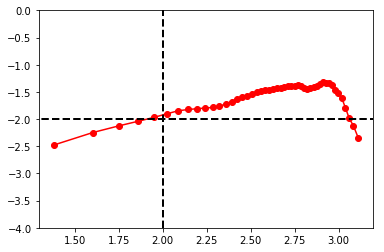

In [8]:
x1_log=np.log10(SF_of_pure_simulation[:,0])
y1_log=np.log10(SF_of_pure_simulation[:,1])
plt.plot(x1_log,y1_log,label='16',marker='o',color='r')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,-4,0))
# draw vertical line from (70,100) to (70, 250)
plt.plot([0,4], [-2, -2], 'k-', lw=2, ls='--')
plt.plot([2,2], [-4, 0], 'k-', lw=2, ls='--')

## Single Slope Example

In [20]:
# array having slopes which I want to create + normalizing amplitudes which assure that each "Main Sequence" 
# has spread of 0.3 dex
slope_and_prefactor=np.c_[np.array([1.0,1.5,2.0,2.5,3.0]),np.array([8.75,3.55,1.04,0.27,0.068])]

In [22]:
# Function which selects a random starting point in the star-formation history curve and takes 500 points after 
# that random point
# Values for slope can be only 1.0, 1.5, 2.0, 2.5, 3.0, i.e, they must have been created before
def create_single_500_LC(i,slope_i):
    single_LC=np.load(base_dir+'/'+str(slope_i)+'/'+str(i)+'.npy')
    t_start=np.random.randint(0,2000-500)
    return single_LC[t_start:t_start+500]# LSFH (length of star-formation history) - nubmer of points describing single star-formation history
# LSFH (length of star-formation history) - nubmer of points describing single star-formation history
LSFH=2000
# N - number of simulated histories, i.e., number of simulated galaxies
N=1000
for j in range(len(slope_and_prefactor)):
    n=slope_and_prefactor[:,0][j]
    os.chdir(base_dir)    
    try:
        os.stat(base_dir+'/'+str(n)+'/')
    except:
        os.mkdir(base_dir+'/'+str(n)+'/')
    os.chdir(base_dir+'/'+str(n)+'/')    
    for i in range(N):
        y=(slope_and_prefactor[:,1][j])*astroML.time_series.generate_power_law(LSFH,dt=1,beta=n)
        np.save(str(i),y)



In [23]:
%%capture
#This cell creates 5 large arrays which contain 1000 SFR histories, each 500 long 
list_of_SFH=range(1000)
SFH10=np.vstack(np.array(map(create_single_500_LC,list_of_SFH,repeat(1.0,len(list_of_SFH)))))
SFH15=np.vstack(np.array(map(create_single_500_LC,list_of_SFH,repeat(1.5,len(list_of_SFH)))))
SFH20=np.vstack(np.array(map(create_single_500_LC,list_of_SFH,repeat(2.0,len(list_of_SFH)))))
SFH25=np.vstack(np.array(map(create_single_500_LC,list_of_SFH,repeat(2.5,len(list_of_SFH)))))
SFH30=np.vstack(np.array(map(create_single_500_LC,list_of_SFH,repeat(3.0,len(list_of_SFH)))))


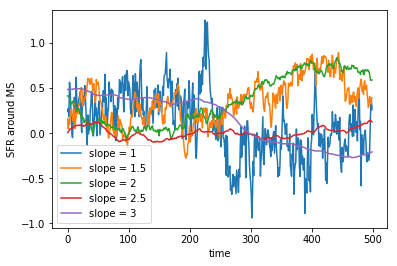

In [45]:
#Showing an example, single SFR history, just to convince myself that is look reasonable
plt.plot(SFH10[0],label='slope = 1')
plt.plot(SFH15[0],label='slope = 1.5')
plt.plot(SFH20[0],label='slope = 2')
plt.plot(SFH25[0],label='slope = 2.5')
plt.plot(SFH30[0],label='slope = 3')
plt.xlabel("time")
plt.ylabel("SFR around MS")

plt.legend()

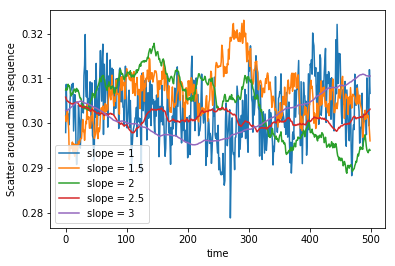

In [25]:
#This shows how does standard deviation look in time - roughly 0.3 dex all the time, for all of the slopes
plt.plot(np.apply_along_axis(np.std, 0, SFH10),label='slope = 1')
plt.plot(np.apply_along_axis(np.std, 0, SFH15),label='slope = 1.5')
plt.plot(np.apply_along_axis(np.std, 0, SFH20),label='slope = 2')
plt.plot(np.apply_along_axis(np.std, 0, SFH25),label='slope = 2.5')
plt.plot(np.apply_along_axis(np.std, 0, SFH30),label='slope = 3')
plt.xlabel("time")
plt.ylabel("Scatter around main sequence")

plt.legend()

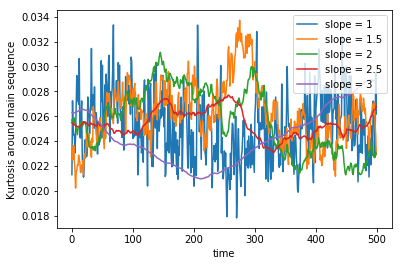

In [42]:
#This shows how does kurtosis look in time - same for all the slopes
plt.plot(scipy.stats.moment(SFH10,moment=4,axis=0),label='slope = 1')
plt.plot(scipy.stats.moment(SFH15,moment=4,axis=0),label='slope = 1.5')
plt.plot(scipy.stats.moment(SFH20,moment=4,axis=0),label='slope = 2')
plt.plot(scipy.stats.moment(SFH25,moment=4,axis=0),label='slope = 2.5')
plt.plot(scipy.stats.moment(SFH30,moment=4,axis=0),label='slope = 3')
plt.xlabel("time")
plt.ylabel("Kurtosis around main sequence")
plt.legend()

Ok, so at the moment there is no difference between different curves.
Lets look at the structure function -> which is a measurable quantity
How to determine structure function from the data
-For each galaxy
1. Measure the SFR at t1 (from one SFR indicator)
2. Measure the SFR at t2 (from another SFR indicator)
3. Calculate difference of SFR(t1) and SFR(t2)
4. Do this for N galaxies, t - result is N measurements of SFR(t1)-SFR(t2) 
5. Calculate the standard deviation of these N measurements -> this is value of structure function at delta t= t2-t1


In [26]:
# function which randomly select a point in the curve and finds the difference at a given 'j' time difference
def value_dif_at_j(a,j):
    random_init=np.random.randint(0,500-j, size=1)[0]
    return (a[random_init]-a[random_init+j]) 

In [27]:
# This creates a list of 5 arrays, each array being structure functior for different slopes
SF_all=[]
for s in [SFH10,SFH15,SFH20,SFH25,SFH30]:
    SF=[]
    items = np.concatenate((np.linspace(2,9,8,dtype=int),np.linspace(10,400,20,dtype=int)),axis=0)
    for i in range(len(items)):
        SF=np.append(SF,np.std(np.apply_along_axis(value_dif_at_j, 1, s,j=items[i])))
    SF=np.transpose(np.vstack([np.log10(items),np.log10(SF)]))
    SF_all.append(SF)

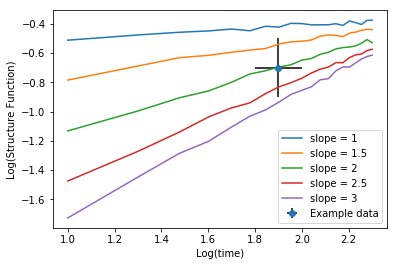

In [69]:
# This create a plot showing different structure functions
# I have also placed one data point, which is what one would get from the data, 
#assuming that all the data is taken at same delta t

#This is basically showing the previous statment that this is enough to determine slope, 
#assuming that we say that PSD/SF can be described as power-law
x0=SF_all[0][:,0]
y0=SF_all[0][:,1]
x1=SF_all[1][:,0]
y1=SF_all[1][:,1]
x2=SF_all[2][:,0]
y2=SF_all[2][:,1]
x3=SF_all[3][:,0]
y3=SF_all[3][:,1]
x4=SF_all[4][:,0]
y4=SF_all[4][:,1]
plt.plot(x0,y0,label='slope = 1')
plt.plot(x1,y1,label='slope = 1.5')
plt.plot(x2,y2,label='slope = 2')
plt.plot(x3,y3,label='slope = 2.5')
plt.plot(x4,y4,label='slope = 3')
plt.errorbar([1.9],[-0.7], xerr=0.1, yerr=0.2,fmt='o', ecolor='black', capthick=3,label='Example data')
plt.xlabel("Log(time)")
plt.ylabel("Log(Structure Function)")
plt.legend()

## Example with breaks - TK code 

In [ ]:
# Lets now assume that PSD/SF has a break at some time-scale

In [392]:
# array having slopes which I want to create + normalizing amplitudes which assure that each "Main Sequence" 
# has spread of 0.3 dex + time scale of the break
slope_and_prefactor=np.c_[np.array([1.0,1.5,2.0,2.5,3.0]),
                          np.array([0.3,0.3,0.3,0.3,0.3]),np.array([1000000,1000000,5000,1500,1000])]

In [393]:
# Function which selects a random starting point in the star-formation history curve and takes 500 points after 
# that random point
# Values for slope can be only 1.0, 1.5, 2.0, 2.5, 3.0, i.e, they must have been created before
def create_single_500_LC(i,slope_i):
    single_LC=np.load(base_dir+'/'+str(slope_i)+'/'+str(i)+'.npy')
    t_start=np.random.randint(0,2000-500)
    return single_LC[t_start:t_start+500]# LSFH (length of star-formation history) - nubmer of points describing single star-formation history
# LSFH (length of star-formation history) - nubmer of points describing single star-formation history
LSFH=2000
# N - number of simulated histories, i.e., number of simulated galaxies
N=200
# Only 100 as this will take a minute or two

for j in range(len(slope_and_prefactor)):
    n=slope_and_prefactor[:,0][j]
    os.chdir(base_dir)    
    try:
        os.stat(base_dir+'/'+str(n)+'/')
    except:
        os.mkdir(base_dir+'/'+str(n)+'/')
    os.chdir(base_dir+'/'+str(n)+'/')    
    for i in range(N):
        delc =Simulate_TK_Lightcurve(BendingPL, (1,1.0/(slope_and_prefactor[:,2][j]),n,0,0.1),
                              RedNoiseL=1,aliasTbin=1,tbin = 1,length=5000)
        y=(slope_and_prefactor[:,1][j])*delc.flux
        np.save(str(i),y)

In [394]:
%%capture
#This cell creates 5 large arrays which contain N times SFR histories, each 500 long 
list_of_SFH=range(N)
SFH10=np.vstack(np.array(map(create_single_500_LC,list_of_SFH,repeat(1.0,len(list_of_SFH)))))
SFH15=np.vstack(np.array(map(create_single_500_LC,list_of_SFH,repeat(1.5,len(list_of_SFH)))))
SFH20=np.vstack(np.array(map(create_single_500_LC,list_of_SFH,repeat(2.0,len(list_of_SFH)))))
SFH25=np.vstack(np.array(map(create_single_500_LC,list_of_SFH,repeat(2.5,len(list_of_SFH)))))
SFH30=np.vstack(np.array(map(create_single_500_LC,list_of_SFH,repeat(3.0,len(list_of_SFH)))))


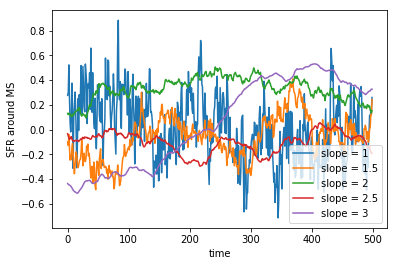

In [395]:
#Showing an example, single SFR history, just to convince myself that is look reasonable
plt.plot(SFH10[0],label='slope = 1')
plt.plot(SFH15[0],label='slope = 1.5')
plt.plot(SFH20[0],label='slope = 2')
plt.plot(SFH25[0],label='slope = 2.5')
plt.plot(SFH30[0],label='slope = 3')
plt.xlabel("time")
plt.ylabel("SFR around MS")

plt.legend()

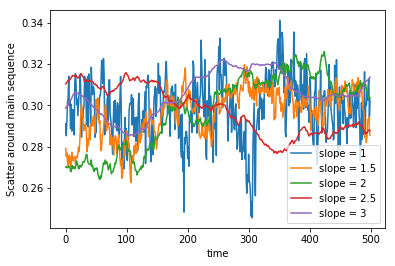

In [396]:
#This shows how does standard deviation look in time - roughly 0.3 dex all the time, for all of the slopes
plt.plot(np.apply_along_axis(np.std, 0, SFH10),label='slope = 1')
plt.plot(np.apply_along_axis(np.std, 0, SFH15),label='slope = 1.5')
plt.plot(np.apply_along_axis(np.std, 0, SFH20),label='slope = 2')
plt.plot(np.apply_along_axis(np.std, 0, SFH25),label='slope = 2.5')
plt.plot(np.apply_along_axis(np.std, 0, SFH30),label='slope = 3')
plt.xlabel("time")
plt.ylabel("Scatter around main sequence")

plt.legend()

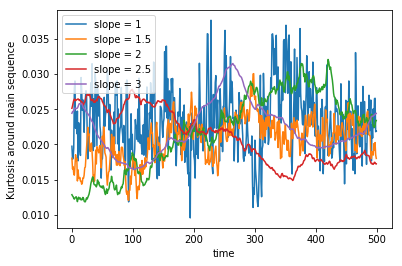

In [397]:
#This shows how does kurtosis look in time - same for all the slopes
plt.plot(scipy.stats.moment(SFH10,moment=4,axis=0),label='slope = 1')
plt.plot(scipy.stats.moment(SFH15,moment=4,axis=0),label='slope = 1.5')
plt.plot(scipy.stats.moment(SFH20,moment=4,axis=0),label='slope = 2')
plt.plot(scipy.stats.moment(SFH25,moment=4,axis=0),label='slope = 2.5')
plt.plot(scipy.stats.moment(SFH30,moment=4,axis=0),label='slope = 3')
plt.xlabel("time")
plt.ylabel("Kurtosis around main sequence")
plt.legend()

In [398]:
# function which randomly select a point in the curve and finds the difference at a given 'j' time difference
def value_dif_at_j(a,j):
    random_init=np.random.randint(0,500-j, size=1)[0]
    return (a[random_init]-a[random_init+j]) 

In [408]:
# This creates a list of 5 arrays, each array being structure functior for different slopes
SF_all=[]
for s in [SFH10,SFH15,SFH20,SFH25,SFH30]:
    SF=[]
    items = np.concatenate((np.linspace(2,9,8,dtype=int),np.linspace(10,400,20,dtype=int)),axis=0)
    for i in range(len(items)):
        SF=np.append(SF,np.std(np.apply_along_axis(value_dif_at_j, 1, s,j=items[i])))
    SF=np.transpose(np.vstack([np.log10(items),np.log10(SF)]))
    SF_all.append(SF)

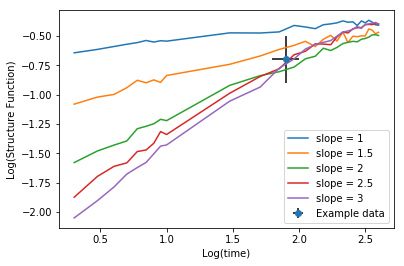

In [409]:
# This create a plot showing different structure functions
# I have also placed one data point, which is what one would get from the data, 
#assuming that all the data is taken at same delta t

#This is basically showing the previous statment that this is enough to determine slope, 
#assuming that we say that PSD/SF can be described as power-law
x0=SF_all[0][:,0]
y0=SF_all[0][:,1]
x1=SF_all[1][:,0]
y1=SF_all[1][:,1]
x2=SF_all[2][:,0]
y2=SF_all[2][:,1]
x3=SF_all[3][:,0]
y3=SF_all[3][:,1]
x4=SF_all[4][:,0]
y4=SF_all[4][:,1]
plt.plot(x0,y0,label='slope = 1')
plt.plot(x1,y1,label='slope = 1.5')
plt.plot(x2,y2,label='slope = 2')
plt.plot(x3,y3,label='slope = 2.5')
plt.plot(x4,y4,label='slope = 3')
plt.errorbar([1.9],[-0.7], xerr=0.1, yerr=0.2,fmt='o', ecolor='black', capthick=3,label='Example data')
plt.xlabel("Log(time)")
plt.ylabel("Log(Structure Function)")
plt.legend()

## Example with breaks - Emmanolopulus code - not finished

In [ ]:
# Lets now assume that PSD/SF has a break at some time-scale

In [2]:
# array having slopes which I want to create + normalizing amplitudes which assure that each "Main Sequence" 
# has spread of 0.3 dex + time scale of the break
slope_and_prefactor=np.c_[np.array([1.0,1.5,2.0,2.5,3.0]),
                          np.array([8.75,3.55,1.04,0.27,0.068]),np.array([50,50,50,50,50])]

In [169]:
# Function which selects a random starting point in the star-formation history curve and takes 500 points after 
# that random point
# Values for slope can be only 1.0, 1.5, 2.0, 2.5, 3.0, i.e, they must have been created before
def create_single_500_LC(i,slope_i):
    single_LC=np.load(base_dir+'/'+str(slope_i)+'/'+str(i)+'.npy')
    t_start=np.random.randint(0,2000-500)
    return single_LC[t_start:t_start+500]# LSFH (length of star-formation history) - nubmer of points describing single star-formation history
# LSFH (length of star-formation history) - nubmer of points describing single star-formation history
LSFH=2000
# N - number of simulated histories, i.e., number of simulated galaxies
N=100
# Only 100 as this will take a minute or two

for j in range(len(slope_and_prefactor)):
    n=slope_and_prefactor[:,0][j]
    os.chdir(base_dir)    
    try:
        os.stat(base_dir+'/'+str(n)+'/')
    except:
        os.mkdir(base_dir+'/'+str(n)+'/')
    os.chdir(base_dir+'/'+str(n)+'/')    
    for i in range(N):
        # paramters for scipy.stats.lognorm (A,v_bend,a_low,a_high,c)
        # paramters for scipy.stats.lognorm -> (0.3 = spread, 0.0 =mean , 7.4=scale)
        delc = Simulate_DE_Lightcurve(BendingPL, (1.0,1.0/100,n,0,0.1),
                                      scipy.stats.lognorm,(0.3, 0, 1),LClength=LSFH,tbin = 1)
        y=np.log(delc.flux)
        np.save(str(i),y)

In [170]:
%%capture
#This cell creates 5 large arrays which contain N times SFR histories, each 500 long 
list_of_SFH=range(N)
SFH10=np.vstack(np.array(map(create_single_500_LC,list_of_SFH,repeat(1.0,len(list_of_SFH)))))
SFH15=np.vstack(np.array(map(create_single_500_LC,list_of_SFH,repeat(1.5,len(list_of_SFH)))))
SFH20=np.vstack(np.array(map(create_single_500_LC,list_of_SFH,repeat(2.0,len(list_of_SFH)))))
SFH25=np.vstack(np.array(map(create_single_500_LC,list_of_SFH,repeat(2.5,len(list_of_SFH)))))
SFH30=np.vstack(np.array(map(create_single_500_LC,list_of_SFH,repeat(3.0,len(list_of_SFH)))))


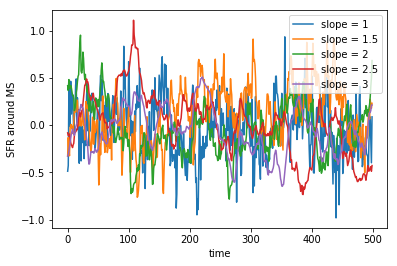

In [171]:
#Showing an example, single SFR history, just to convince myself that is look reasonable
plt.plot(SFH10[0],label='slope = 1')
plt.plot(SFH15[0],label='slope = 1.5')
plt.plot(SFH20[0],label='slope = 2')
plt.plot(SFH25[0],label='slope = 2.5')
plt.plot(SFH30[0],label='slope = 3')
plt.xlabel("time")
plt.ylabel("SFR around MS")

plt.legend()

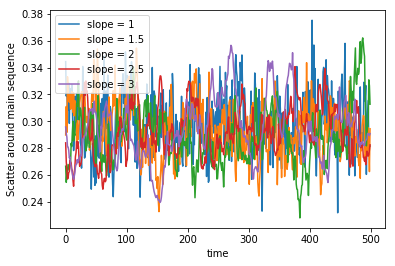

In [172]:
#This shows how does standard deviation look in time - roughly 0.3 dex all the time, for all of the slopes
plt.plot(np.apply_along_axis(np.std, 0, SFH10),label='slope = 1')
plt.plot(np.apply_along_axis(np.std, 0, SFH15),label='slope = 1.5')
plt.plot(np.apply_along_axis(np.std, 0, SFH20),label='slope = 2')
plt.plot(np.apply_along_axis(np.std, 0, SFH25),label='slope = 2.5')
plt.plot(np.apply_along_axis(np.std, 0, SFH30),label='slope = 3')
plt.xlabel("time")
plt.ylabel("Scatter around main sequence")

plt.legend()

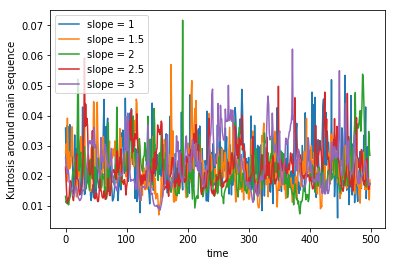

In [173]:
#This shows how does kurtosis look in time - same for all the slopes
plt.plot(scipy.stats.moment(SFH10,moment=4,axis=0),label='slope = 1')
plt.plot(scipy.stats.moment(SFH15,moment=4,axis=0),label='slope = 1.5')
plt.plot(scipy.stats.moment(SFH20,moment=4,axis=0),label='slope = 2')
plt.plot(scipy.stats.moment(SFH25,moment=4,axis=0),label='slope = 2.5')
plt.plot(scipy.stats.moment(SFH30,moment=4,axis=0),label='slope = 3')
plt.xlabel("time")
plt.ylabel("Kurtosis around main sequence")
plt.legend()

In [174]:
# function which randomly select a point in the curve and finds the difference at a given 'j' time difference
def value_dif_at_j(a,j):
    random_init=np.random.randint(0,500-j, size=1)[0]
    return (a[random_init]-a[random_init+j]) 

In [175]:
# This creates a list of 5 arrays, each array being structure functior for different slopes
SF_all=[]
for s in [SFH10,SFH15,SFH20,SFH25,SFH30]:
    SF=[]
    items = np.linspace(10,200,20,dtype=int)
    for i in range(len(items)):
        SF=np.append(SF,np.std(np.apply_along_axis(value_dif_at_j, 1, s,j=items[i])))
    SF=np.transpose(np.vstack([np.log10(items),np.log10(SF)]))
    SF_all.append(SF)

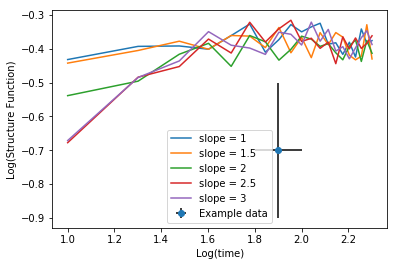

In [176]:
# This create a plot showing different structure functions
# I have also placed one data point, which is what one would get from the data, 
#assuming that all the data is taken at same delta t

#This is basically showing the previous statment that this is enough to determine slope, 
#assuming that we say that PSD/SF can be described as power-law
x0=SF_all[0][:,0]
y0=SF_all[0][:,1]
x1=SF_all[1][:,0]
y1=SF_all[1][:,1]
x2=SF_all[2][:,0]
y2=SF_all[2][:,1]
x3=SF_all[3][:,0]
y3=SF_all[3][:,1]
x4=SF_all[4][:,0]
y4=SF_all[4][:,1]
plt.plot(x0,y0,label='slope = 1')
plt.plot(x1,y1,label='slope = 1.5')
plt.plot(x2,y2,label='slope = 2')
plt.plot(x3,y3,label='slope = 2.5')
plt.plot(x4,y4,label='slope = 3')
plt.errorbar([1.9],[-0.7], xerr=0.1, yerr=0.2,fmt='o', ecolor='black', capthick=3,label='Example data')
plt.xlabel("Log(time)")
plt.ylabel("Log(Structure Function)")
plt.legend()

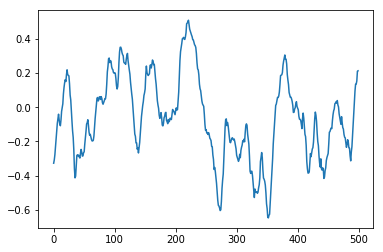

In [177]:
plt.plot(SFH30[0])

In [219]:
delc = Simulate_DE_Lightcurve(BendingPL, (1.0,1.0/10000,3,0,0.01),
                              scipy.stats.lognorm,(0.3, 0, 1),LClength=LSFH)
y=np.log(delc.flux)

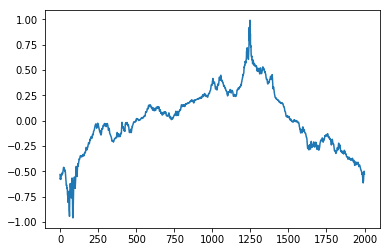

In [220]:
plt.plot(y)

In [180]:
ligth_curve_sort_and_clean=np.c_[(range(0,len(y)),y)]
SF_of_pure_simulation=compute_sf_log(ligth_curve_sort_and_clean)

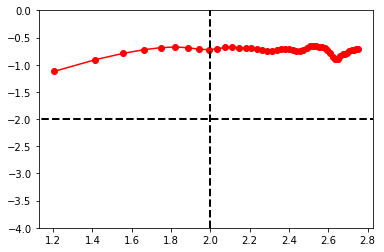

In [181]:
x1_log=np.log10(SF_of_pure_simulation[:,0])
y1_log=np.log10(SF_of_pure_simulation[:,1])
plt.plot(x1_log,y1_log,label='16',marker='o',color='r')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,-4,0))
# draw vertical line from (70,100) to (70, 250)
plt.plot([0,4], [-2, -2], 'k-', lw=2, ls='--')
plt.plot([2,2], [-4, 0], 'k-', lw=2, ls='--')

In [212]:
for i in range(N):
    # paramters for scipy.stats.lognorm (A,v_bend,a_low,a_high,c)
    # paramters for scipy.stats.lognorm -> (0.3 = spread, 0.0 =mean , 7.4=scale)
    delc = Simulate_DE_Lightcurve(BendingPL, (1,1.0/10,3,0,0.0),
                                  scipy.stats.lognorm,(0.3, 0, 1),LClength=LSFH,tbin = 1)
    y=np.log(delc.flux)
    np.save(str(i),y)

In [213]:
%%capture
#This cell creates 5 large arrays which contain N times SFR histories, each 500 long 
list_of_SFH=range(N)
SFH30=np.vstack(np.array(map(create_single_500_LC,list_of_SFH,repeat(3.0,len(list_of_SFH)))))

In [214]:
# This creates a list of 5 arrays, each array being structure functior for different slopes
SF_all=[]
for s in [SFH10,SFH15,SFH20,SFH25,SFH30]:
    SF=[]
    items = np.linspace(10,200,20,dtype=int)
    for i in range(len(items)):
        SF=np.append(SF,np.std(np.apply_along_axis(value_dif_at_j, 1, s,j=items[i])))
    SF=np.transpose(np.vstack([np.log10(items),np.log10(SF)]))
    SF_all.append(SF)

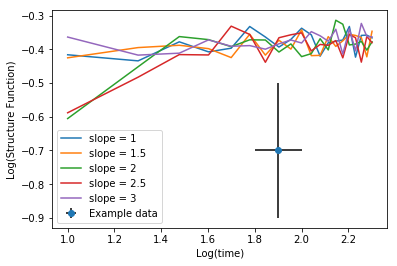

In [215]:
# This create a plot showing different structure functions
# I have also placed one data point, which is what one would get from the data, 
#assuming that all the data is taken at same delta t

#This is basically showing the previous statment that this is enough to determine slope, 
#assuming that we say that PSD/SF can be described as power-law
x0=SF_all[0][:,0]
y0=SF_all[0][:,1]
x1=SF_all[1][:,0]
y1=SF_all[1][:,1]
x2=SF_all[2][:,0]
y2=SF_all[2][:,1]
x3=SF_all[3][:,0]
y3=SF_all[3][:,1]
x4=SF_all[4][:,0]
y4=SF_all[4][:,1]
plt.plot(x0,y0,label='slope = 1')
plt.plot(x1,y1,label='slope = 1.5')
plt.plot(x2,y2,label='slope = 2')
plt.plot(x3,y3,label='slope = 2.5')
plt.plot(x4,y4,label='slope = 3')
plt.errorbar([1.9],[-0.7], xerr=0.1, yerr=0.2,fmt='o', ecolor='black', capthick=3,label='Example data')
plt.xlabel("Log(time)")
plt.ylabel("Log(Structure Function)")
plt.legend()

In [252]:
delc = Simulate_DE_Lightcurve(BendingPL, (10000,1.0/1000000,3,0,0),
                              scipy.stats.lognorm,(0.3, 0, 1),LClength=LSFH,tbin = 1)
y=np.log(delc.flux)

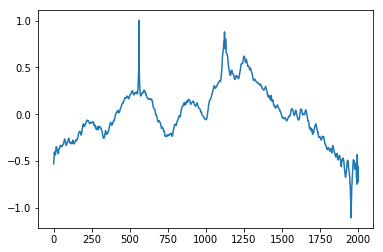

In [240]:
plt.plot(y)

In [241]:
astroML.time_series.generate_power_law(LSFH,dt=1,beta=n)

array([-3.6979487 , -3.65982203, -3.61992663, ..., -3.7256062 ,
       -3.734863  , -3.72567369])

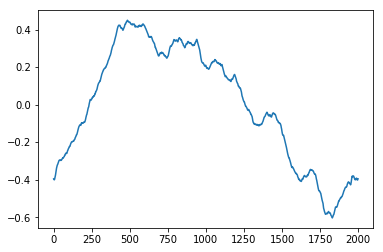

In [242]:
plt.plot(0.068*astroML.time_series.generate_power_law(LSFH,dt=1,beta=3))

(array([ 410.,  268.,  105.,  296.,  173.,  124.,   86.,   99.,  147.,  292.]),
 array([-0.4713471 , -0.36305965, -0.25477219, -0.14648473, -0.03819728,
         0.07009018,  0.17837764,  0.28666509,  0.39495255,  0.50324001,
         0.61152746]),
 <a list of 10 Patch objects>)

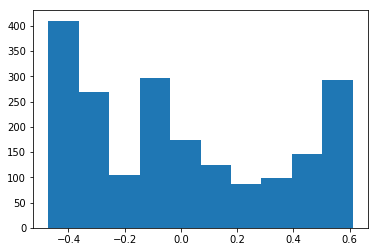

In [250]:
plt.hist(0.068*astroML.time_series.generate_power_law(LSFH,dt=1,beta=3))

(array([ 148.,  101.,  278.,  382.,  214.,  280.,  134.,  159.,  178.,  127.]),
 array([-1.88088641, -1.48791091, -1.09493541, -0.70195991, -0.30898442,
         0.08399108,  0.47696658,  0.86994208,  1.26291758,  1.65589308,
         2.04886858]),
 <a list of 10 Patch objects>)

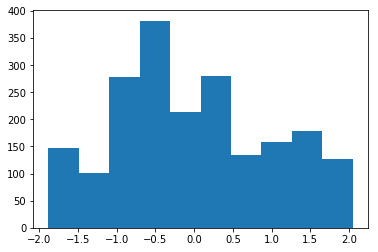

In [271]:
plt.hist(y)

In [278]:
delc = Simulate_TK_Lightcurve(BendingPL, (0.1,1.0/1000000,3,0,0),
                              RedNoiseL=1,aliasTbin=1,tbin = 1,length=2000)
y=delc.flux

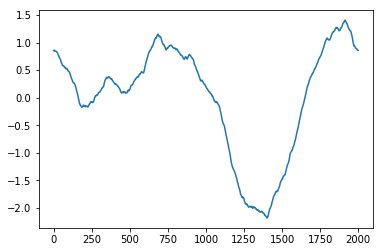

In [279]:
plt.plot(y)

# Illustris data

In [188]:
import numpy as np

np.set_printoptions(suppress=True)

import matplotlib
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 22})
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
"""
tracking_99_21_10.4_10.6.fits => selected galaxies at z=0 with masses between 10.4-10.6
tracking_50_21_10.4_10.6.fits => selected galaxies at z=1 with masses between 10.4-10.6
tracking_99_21_10.8_11.0.fits => selected galaxies at z=0 with masses between 10.8-11.0

[‘galaxy_ID’, ‘scalefactor’, ‘redshift’, ‘time’, ‘log_Mstar’, ‘log_Mgas’, ‘log_Mbh’, ‘log_SFR’, ‘DMS’, ‘Rstar’, ‘Rgas’, ‘metallicity’, ‘metallicity_SF’, ‘BHacc’]
‘galaxy_ID’ is a list that includes the ID of all galaxies 
(let’s assume that there are N galaxies). 
Each other column contains a NxM matrix,
where N are the different galaxies, and M are the values at the different timesteps. 
The timesteps are given by ‘scalefactor’, ‘redshift’, ‘time’.
There are nan values if the galaxy was not found in a snapshot (should be rare).


"""




In [405]:
from astropy.table import Table
table_evo1 = Table.read('/Users/nevencaplar/Documents/Variability/MainSequence/Illustris/'+\
                        'tracking_50_21_10.4_10.6.fits', format='fits')
table_evo2 = Table.read('/Users/nevencaplar/Documents/Variability/MainSequence/Illustris/'+\
                        'tracking_99_21_10.4_10.6.fits', format='fits')
table_evo3 = Table.read('/Users/nevencaplar/Documents/Variability/MainSequence/Illustris/'+\
                        'tracking_99_21_10.8_11.0.fits', format='fits')

In [58]:
table_evo1

galaxy_ID,scalefactor [30],redshift [30],time [30],log_Mstar [30],log_Mgas [30],log_Mbh [30],log_SFR [30],DMS [30],Rstar [30],Rgas [30],metallicity [30],metallicity_SF [30],BHacc [30]
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
152218.0,50.0 .. 21.0,0.997294225782 .. 4.00794511147,5.8735458292 .. 1.53745700275,10.5789813995 .. 9.86281776428,11.0288190842 .. 10.7031679153,8.49220275879 .. 6.90351247787,-0.365458011627 .. 1.52207779884,-1.39473000749 .. 0.152228826553,2.42308306694 .. 2.72197318077,147.416976929 .. 73.3701858521,0.00537211913615 .. 0.0146947149187,0.00557473441586 .. 0.00814153067768,2.43432095886e-05 .. 0.00234226207249
175669.0,50.0 .. 21.0,0.997294225782 .. 4.00794511147,5.8735458292 .. 1.53745700275,10.4850387573 .. 8.6629743576,11.7060852051 .. 9.90393066406,7.90834712982 .. 6.11787986755,1.2140570879 .. 0.0691695958376,0.256319247421 .. -0.410243103612,4.47679281235 .. 7.20633363724,161.663040161 .. 45.6569061279,0.0318981036544 .. 0.00444908626378,0.0116535788402 .. 0.00434464775026,0.012276571244 .. 5.02428592881e-05
181407.0,50.0 .. 21.0,0.997294225782 .. 4.00794511147,5.8735458292 .. 1.53745700275,10.4544582367 .. 8.60562229156,11.4943189621 .. 9.9748506546,7.95994997025 .. 6.10366010666,1.23263990879 .. 0.196092396975,0.29850958719 .. -0.283320302475,2.4721467495 .. 8.47038269043,153.171630859 .. 54.0988807678,0.0245505347848 .. 0.00330383330584,0.0145860724151 .. 0.00346979591995,0.00374995637685 .. 5.8637753682e-05
195829.0,50.0 .. 21.0,0.997294225782 .. 4.00794511147,5.8735458292 .. 1.53745700275,10.5579719543 .. 9.68863582611,11.09486866 .. 10.5287685394,8.46858692169 .. 6.48354148865,0.280831187963 .. 1.25844836235,-0.73250960683 .. 0.019049862926,1.77413499355 .. 3.31472635269,124.167457581 .. 59.2290306091,0.0060501806438 .. 0.0121811414137,0.00465096253902 .. 0.00722441496328,0.000312139920425 .. 0.00164076127112
205454.0,50.0 .. 21.0,0.997294225782 .. 4.00794511147,5.8735458292 .. 1.53745700275,10.5830307007 .. 9.41806983948,11.400683403 .. 10.4119110107,8.42115211487 .. 6.33497571945,0.917342126369 .. 0.951476335526,-0.11500040421 .. -0.00377311940646,2.10644173622 .. 4.15152311325,108.089538574 .. 52.5776634216,0.00393526395783 .. 0.00909847952425,0.00258688535541 .. 0.00609803106636,2.82126711681e-05 .. 0.000225858850172
205976.0,50.0 .. 21.0,0.997294225782 .. 4.00794511147,5.8735458292 .. 1.53745700275,10.5435037613 .. 8.22242164612,11.2452249527 .. 9.78786563873,8.00345230103 .. -inf,1.13880002499 .. -0.115114554763,0.136430281098 .. -0.594527254213,5.9863524437 .. 6.12984228134,116.611228943 .. 56.2122840881,0.0233812406659 .. 0.00305097480305,0.0184089057148 .. 0.0032594089862,0.00300640938804 .. 0.0
206445.0,50.0 .. 21.0,0.997294225782 .. 4.00794511147,5.8735458292 .. 1.53745700275,10.5389728546 .. 7.88228225708,11.4614810944 .. 9.73806095123,7.74225664139 .. -inf,1.04750168324 .. -0.591318845749,0.0485676695461 .. -1.0707315452,11.9251928329 .. 4.99346160889,137.180831909 .. 46.0041847229,0.016466954723 .. 0.00283459271304,0.0146401161328 .. 0.0023145400919,0.00225022761151 .. 0.0
209396.0,50.0 .. 21.0,0.997294225782 .. 4.00794511147,5.8735458292 .. 1.53745700275,10.5031023026 .. 8.46216678619,11.5345058441 .. 9.95334720612,7.47787809372 .. 6.10057353973,1.24850928783 .. 0.0617965720594,0.276826770284 .. -0.417616127391,8.13383960724 .. 8.39468002319,138.923736572 .. 55.0648231506,0.0188170559704 .. 0.00335088162683,0.0144128883258 .. 0.00373693462461,0.000761201954447 .. 8.77511920407e-05
213278.0,50.0 .. 21.0,0.997294225782 .. 4.00794511147,5.8735458292 .. 1.53745700275,10.5455112457 .. 8.93102359772,11.1880741119 .. 10.2095184326,8.17731285095 .. 6.16067075729,1.58132791519 .. 0.294555544853,0.577435920815 .. -0.184857154597,2.35525608063 .. 8.14393615723,133.910018921 .. 57.4319801331,0.027910746634 .. 0.00637971097603,0.0247898735106 .. 0.00469924882054,0.0121761392802 .. 8.26220857562e-05


In [86]:
table_evo2

galaxy_ID,scalefactor [79],redshift [79],time [79],log_Mstar [79],log_Mgas [79],log_Mbh [79],log_SFR [79],DMS [79],Rstar [79],Rgas [79],metallicity [79],metallicity_SF [79],BHacc [79]
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
383118.0,99.0 .. 21.0,2.22044604925e-16 .. 4.00794511147,13.7976174558 .. 1.53745700275,10.4658384323 .. 8.7271270752,11.0806818008 .. 9.85478401184,8.09733200073 .. 6.11482191086,0.67231464386 .. 0.0829782262444,0.276294751247 .. -0.396434473205,2.72957491875 .. 3.78236722946,71.4084091187 .. 43.7959136963,0.0263572894037 .. 0.0063035399653,0.0197232235223 .. 0.00513865146786,0.00239683873951 .. 8.05784657132e-05
383506.0,99.0 .. 21.0,2.22044604925e-16 .. 4.00794511147,13.7976174558 .. 1.53745700275,10.5932226181 .. 9.04553127289,10.6604957581 .. 10.3712453842,8.37016010284 .. 6.17503595352,-1.88050055504 .. 0.579694867134,-2.2996699554 .. 0.0564558082572,1.90480172634 .. 10.5720930099,87.7880935669 .. 51.1352462769,0.00676756352186 .. 0.00359641946852,0.00546027207747 .. 0.00345160765573,4.16047005274e-05 .. 9.04561820789e-05
400694.0,99.0 .. 21.0,2.22044604925e-16 .. 4.00794511147,13.7976174558 .. 1.53745700275,10.5993480682 .. 9.66706180573,11.1143808365 .. 10.8150377274,8.51163482666 .. 6.31988430023,-inf .. 1.60382640362,-inf .. 0.387058924349,1.79561495781 .. 5.80725812912,193.057022095 .. 70.5977325439,0.00757926050574 .. 0.00883590336889,0.0 .. 0.00492515042424,4.90073489345e-06 .. 0.00198397645727
406136.0,99.0 .. 21.0,2.22044604925e-16 .. 4.00794511147,13.7976174558 .. 1.53745700275,10.4986400604 .. 8.04648780823,11.4539632797 .. 9.61603355408,7.93860673904 .. -inf,1.05405247211 .. -0.502351343632,0.646068200034 .. -0.981764043082,5.52859163284 .. 9.1013841629,74.8374481201 .. 35.903049469,0.00961383897811 .. 0.00183826871216,0.00900981761515 .. 0.0021068030037,0.0020223997999 .. 0.0
410887.0,99.0 .. 21.0,2.22044604925e-16 .. 4.00794511147,13.7976174558 .. 1.53745700275,10.5471801758 .. 8.51365375519,11.3695087433 .. 9.87192726135,7.90838670731 .. 6.07686233521,0.67574763298 .. -0.217636570334,0.257405656509 .. -0.697049269784,4.49892711639 .. 4.42534685135,126.609870911 .. 45.7294807434,0.020692769438 .. 0.00517221912742,0.0192106068134 .. 0.00392070179805,1.92786978914e-06 .. 4.15308968513e-05
412332.0,99.0 .. 21.0,2.22044604925e-16 .. 4.00794511147,13.7976174558 .. 1.53745700275,10.5558757782 .. 7.89714384079,11.1853437424 .. 9.43792819977,7.9141998291 .. -inf,0.230600863695 .. -0.719756424427,-0.187897380533 .. -1.19916912388,3.82341814041 .. 6.86336994171,116.049743652 .. 34.6457519531,0.0263135805726 .. 0.00250076758675,0.0295084770769 .. 0.00243825209327,0.00102592492476 .. 0.0
412911.0,99.0 .. 21.0,2.22044604925e-16 .. 4.00794511147,13.7976174558 .. 1.53745700275,10.4049081802 .. 9.21212005615,10.7351856232 .. 10.4999809265,8.34314250946 .. 6.25064277649,-inf .. 0.689804494381,-inf .. -0.0188970059841,1.11001443863 .. 6.67908859253,100.520469666 .. 78.0637817383,0.00263160048053 .. 0.00662179244682,0.0 .. 0.00402088649571,4.14660632941e-07 .. 0.000162367767189
413463.0,99.0 .. 21.0,2.22044604925e-16 .. 4.00794511147,13.7976174558 .. 1.53745700275,10.5754623413 .. 9.87360954285,10.8229560852 .. 10.7056016922,8.40795516968 .. 6.80467557907,-inf .. 1.41883480549,-inf .. 0.0403275336504,1.77851593494 .. 4.6587600708,127.913162231 .. 74.9228591919,0.0110804298893 .. 0.0140092205256,0.0 .. 0.0103238886222,3.19527345027e-07 .. 0.00557827204466
415496.0,99.0 .. 21.0,2.22044604925e-16 .. 4.00794511147,13.7976174558 .. 1.53745700275,10.5694274902 .. 8.55343437195,11.2463340759 .. 9.93218231201,8.07789039612 .. 6.08521461487,0.699689328671 .. -0.234559968114,0.280947548051 .. -0.713972667564,4.64266395569 .. 5.66712713242,98.2216033936 .. 56.305721283,0.0185289178044 .. 0.00550519954413,0.0174141805619 .. 0.00428231898695,0.000711227592546 .. 3.06989204546e-05


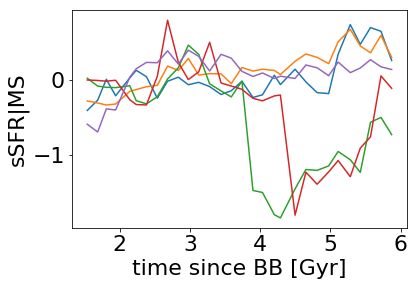

In [89]:
scalefactor=table_evo1[1]['scalefactor']
redshift=table_evo1[1]['redshift']
time=table_evo1[1]['time']
dms=table_evo1[1]['DMS']

plt.plot(time,table_evo1[1]['DMS'])
plt.plot(time,table_evo1[2]['DMS'])
plt.plot(time,table_evo1[3]['DMS'])
plt.plot(time,table_evo1[4]['DMS'])
plt.plot(time,table_evo1[5]['DMS'])
plt.xlabel('time since BB [Gyr]')
plt.ylabel('sSFR|MS')

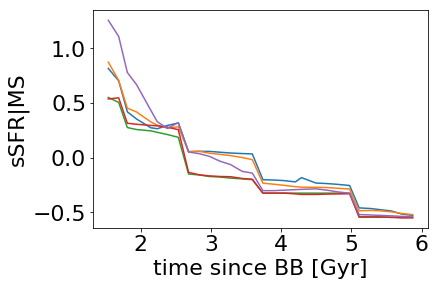

In [87]:
plt.plot(time,table_evo1[1]['log_SFR']-table_evo1[1]['log_Mstar']+9-table_evo1[1]['DMS'])
plt.plot(time,table_evo1[2]['log_SFR']-table_evo1[2]['log_Mstar']+9-table_evo1[2]['DMS'])
plt.plot(time,table_evo1[3]['log_SFR']-table_evo1[3]['log_Mstar']+9-table_evo1[3]['DMS'])
plt.plot(time,table_evo1[4]['log_SFR']-table_evo1[4]['log_Mstar']+9-table_evo1[4]['DMS'])
plt.plot(time,table_evo1[5]['log_SFR']-table_evo1[5]['log_Mstar']+9-table_evo1[5]['DMS'])
plt.xlabel('time since BB [Gyr]')
plt.ylabel('sSFR|MS')

## Determining MS

(array([  2.20000000e+01,   1.60000000e+01,   2.70000000e+01,
          2.20000000e+01,   2.60000000e+01,   3.30000000e+01,
          2.70000000e+01,   3.70000000e+01,   4.60000000e+01,
          3.70000000e+01,   3.90000000e+01,   3.70000000e+01,
          4.30000000e+01,   4.30000000e+01,   4.70000000e+01,
          5.60000000e+01,   5.30000000e+01,   5.20000000e+01,
          6.30000000e+01,   7.40000000e+01,   8.10000000e+01,
          7.70000000e+01,   1.11000000e+02,   1.48000000e+02,
          1.99000000e+02,   2.41000000e+02,   3.67000000e+02,
          5.04000000e+02,   7.63000000e+02,   1.12100000e+03,
          1.42700000e+03,   1.91100000e+03,   2.04500000e+03,
          2.14600000e+03,   1.94900000e+03,   1.53300000e+03,
          1.19400000e+03,   8.09000000e+02,   4.94000000e+02,
          3.16000000e+02,   2.10000000e+02,   1.12000000e+02,
          5.00000000e+01,   4.50000000e+01,   2.30000000e+01,
          1.00000000e+01,   4.00000000e+00,   4.00000000e+00,
        

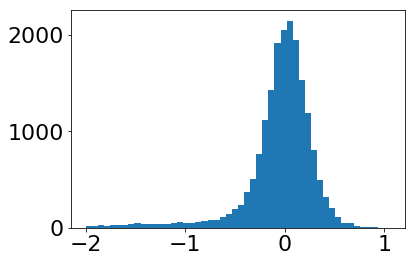

In [92]:
# Distribution around mean of MS
plt.hist(table_evo1['DMS'][table_evo1['DMS']>-2],50)

In [127]:
Kinda_MS_Function_of_Time=table_evo2['log_SFR']-table_evo2['log_Mstar']+9-table_evo2['DMS']
time2=table_evo2[0]['time']
z2=table_evo2[0]['redshift']
scalefactor2=table_evo2[0]['scalefactor']
def mean_funs(a):
    return np.mean(a[~np.isnan(a)])
Kinda_MS_Function_of_Time=np.apply_along_axis(mean_funs,0,Kinda_MS_Function_of_Time)

/Users/nevencaplar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.


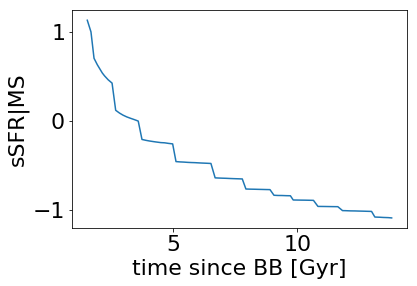

In [126]:
plt.plot(time2,Kinda_MS_Function_of_Time)
plt.xlabel('time since BB [Gyr]')
plt.ylabel('sSFR|MS')

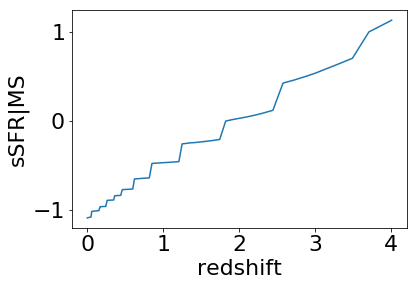

In [132]:
plt.plot(z2,Kinda_MS_Function_of_Time)
plt.xlabel('redshift')
plt.ylabel('sSFR|MS')

## Doing analysis in cosmic time

### Lomb-Scargle 

#### Conceptual example 

In [567]:
from astroML.time_series import generate_damped_RW
from astroML.time_series import lomb_scargle

In [654]:
t=np.arange(0,1000)
y=generate_damped_RW(t,tau=100,random_state=30)
dy=np.ones(len(t))
P=30
#y=np.sin(2*np.pi*t/P)
period = 10 ** np.linspace(1, 3, 10000)
omega = 2 * np.pi / period

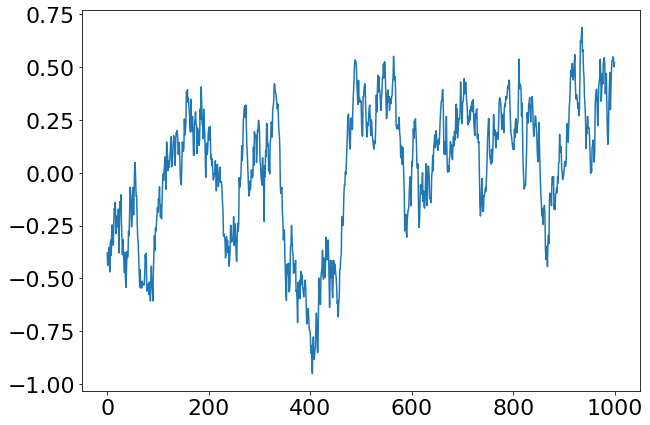

In [655]:
plt.plot(t,y)

In [656]:
P_LS=lomb_scargle(t,y,dy,omega,generalized=True)

[]

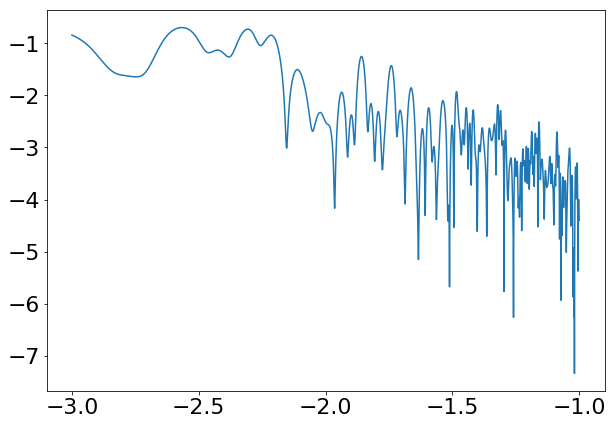

In [657]:
plt.plot(np.log10(1/period),np.log10(P_LS))
plt.plot(ymax=1)

In [ ]:
# For my own understanding - what does random walk produce when you apply LS

In [645]:
from astroML.time_series import generate_damped_RW

y=generate_damped_RW(t,tau=30000, random_state=0)
omega=np.linspace(1,1000,100)

In [173]:
P_LS=lomb_scargle(t,t,0.0001,omega)

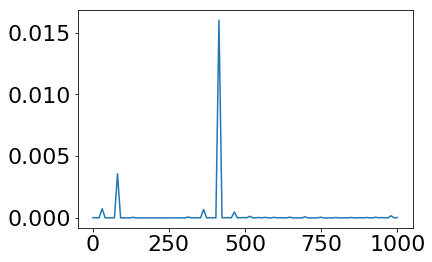

In [174]:
plt.plot(omega,P_LS)

In [175]:
from scipy import signal

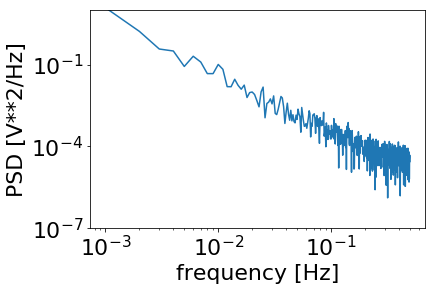

In [179]:
>>> f, Pxx_den = signal.periodogram(y)
>>> plt.loglog(f, Pxx_den)
>>> plt.ylim([1e-7, 1e1])
>>> plt.xlabel('frequency [Hz]')
>>> plt.ylabel('PSD [V**2/Hz]')
>>> plt.show()

#### Single example 

In [658]:
time_single_analysis=table_evo2[0]['time']
dms_single_analysis=table_evo2[0]['DMS']

In [664]:
dy=np.ones(len(time_single_analysis))/1000
period = 10 ** np.linspace(0, 1.2, 1000)
omega = 2 * np.pi / period
frequency=1/period
P_LS=lomb_scargle(time_single_analysis,dms_single_analysis,dy,omega,generalized=True)

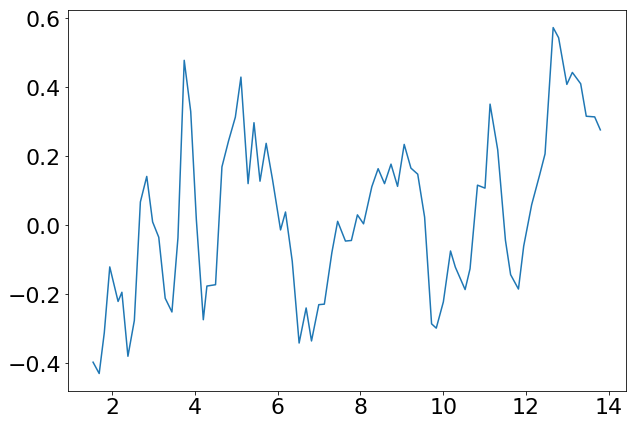

In [665]:
plt.plot(time_single_analysis,dms_single_analysis)

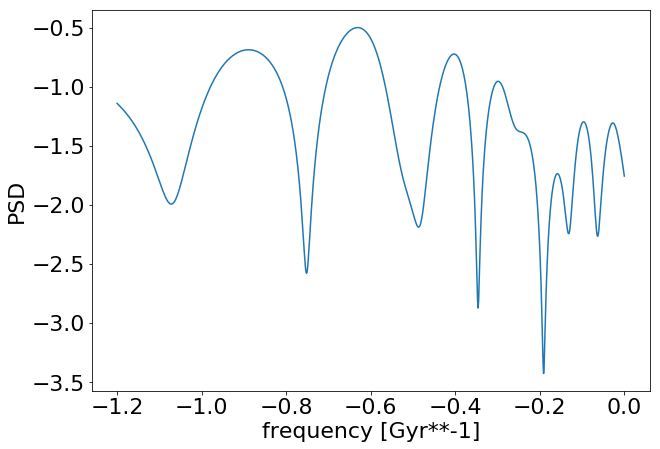

In [667]:
plt.plot(np.log10(frequency),np.log10(P_LS))
plt.plot(ymax=1)
plt.xlabel('frequency [Gyr**-1]')
plt.ylabel('PSD')

### SF analysis

In [287]:
def compute_sf_log(ligth_curve_sort_and_clean):
    """
    Input: 2d numpy array, sorted in time
    """
    array_of_magnitude_differences = [];
    for n in range(len(ligth_curve_sort_and_clean)-1):
        array_of_magnitude_differences.append(ligth_curve_sort_and_clean[n]-ligth_curve_sort_and_clean[n+1:])
    array_of_magnitude_differences=np.vstack(array_of_magnitude_differences)
    array_of_magnitude_differences[:,0]=array_of_magnitude_differences[:,0]*(-1)
    Structure_Function_Log_Bins = [];
    Array_Of_Log_Limits=np.percentile(np.log10(array_of_magnitude_differences[:,0]),range(0,70,5))
    for n in range(1,len(Array_Of_Log_Limits)-1):
        single_bin=array_of_magnitude_differences[((Array_Of_Log_Limits[n])<=(np.log10(array_of_magnitude_differences[:,0])))&((np.log10(array_of_magnitude_differences[:,0]))<=Array_Of_Log_Limits[n+1])]   
        Structure_Function_Log_Bins.append([np.mean(single_bin[:,0]),np.var(single_bin[:,1])])
    Structure_Function_Log_Bins5=np.vstack(Structure_Function_Log_Bins)
    return Structure_Function_Log_Bins5

#### Single example 

In [ ]:
# Show SF**2 for single SFH curve
time_single_analysis=table_evo2[0]['time']
dms_single_analysis=table_evo2[0]['DMS']

In [209]:
ligth_curve_sort_and_clean=np.c_[time_single_analysis,dms_single_analysis]
ligth_curve_sort_and_clean=ligth_curve_sort_and_clean[np.argsort(ligth_curve_sort_and_clean[:, 0])]

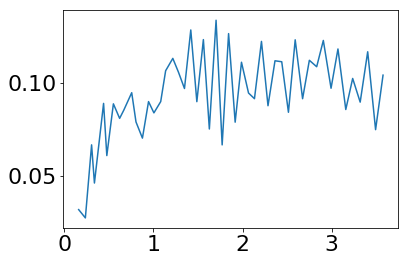

In [213]:
res=compute_sf_log(ligth_curve_sort_and_clean)
plt.plot(res[:,0],res[:,1])

#### Many 

In [553]:
from astropy.stats import bootstrap

# This creates SF**2 from ensamble
def create_SF2_from_Illustris_output(table_evo):
    time_many_analysis=[]
    dmg_many_analysis=[]
    array_of_magnitude_differences = [0,0];


    #only 200 curves so not too long
    for i in np.random.randint(len(table_evo),size=100):
        time_single_analysis=table_evo[i]['time']
        dms_single_analysis=table_evo[i]['DMS']
        if np.max(abs(dms_single_analysis))<1:
            ligth_curve_sort_and_clean=np.c_[time_single_analysis,dms_single_analysis]
            ligth_curve_sort_and_clean=ligth_curve_sort_and_clean[np.argsort(ligth_curve_sort_and_clean[:, 0])]
            for n in range(len(ligth_curve_sort_and_clean)-1):
                array_of_magnitude_differences=np.vstack((array_of_magnitude_differences,
                                                          ligth_curve_sort_and_clean[n]-ligth_curve_sort_and_clean[n+1:]))            
                array_of_magnitude_differences[:,0]=abs(array_of_magnitude_differences[:,0])


    array_of_magnitude_differences=array_of_magnitude_differences[1:]
    array_of_magnitude_differences=array_of_magnitude_differences[np.argsort(array_of_magnitude_differences[:, 0])]

    Array_Of_Log_Limits=np.percentile(np.log10(array_of_magnitude_differences[:,0]),range(0,50,1))
    Structure_Function_Log_Bins=[]
    for n in range(1,len(Array_Of_Log_Limits)-1):
        single_bin=array_of_magnitude_differences[((Array_Of_Log_Limits[n])
                                                   <=(np.log10(array_of_magnitude_differences[:,0])))&((np.log10(array_of_magnitude_differences[:,0]))<=Array_Of_Log_Limits[n+1])]   
        collection_of_samples=np.apply_along_axis(np.var,0,bootstrap(single_bin[:,1], 100))
        Structure_Function_Log_Bins.append([np.mean(np.log10(single_bin[:,0])),
                                            np.mean(np.log10(collection_of_samples)),
                                            np.std(np.log10(collection_of_samples))])
    Structure_Function_Log_Bins=np.vstack(Structure_Function_Log_Bins)
    return Structure_Function_Log_Bins


In [557]:
SF2evo1=create_SF2_from_Illustris_output(table_evo1)
SF2evo2=create_SF2_from_Illustris_output(table_evo2)
SF2evo3=create_SF2_from_Illustris_output(table_evo3)

In [558]:
# Main Sequence spread is around 0.25 dex
# Variance is 0.06
np.var(table_evo1['DMS'][:,0][np.abs(table_evo1['DMS'][:,0])<1])

0.065492942818489192

In [ ]:
### I want to understand why are the curves above dashed line

In [540]:
from astroML.time_series import generate_power_law
ligth_curve_sort_and_clean_list=[]
for i in range(len(table_evo2)):
    y=generate_power_law(N=len(table_evo2[0]['time']),dt=1,beta=0)
    ampl=0.25/np.std(y)
    y=ampl*y
    ligth_curve_sort_and_clean=np.c_[time,y]
    ligth_curve_sort_and_clean=ligth_curve_sort_and_clean[np.argsort(ligth_curve_sort_and_clean[:, 0])]
    ligth_curve_sort_and_clean_list.append(np.transpose(ligth_curve_sort_and_clean))
    


In [541]:
table_evo_sim=Table(np.array(ligth_curve_sort_and_clean_list),names=['time', 'DMS'])

In [554]:
SF2evo_sim=create_SF2_from_Illustris_output(table_evo_sim)

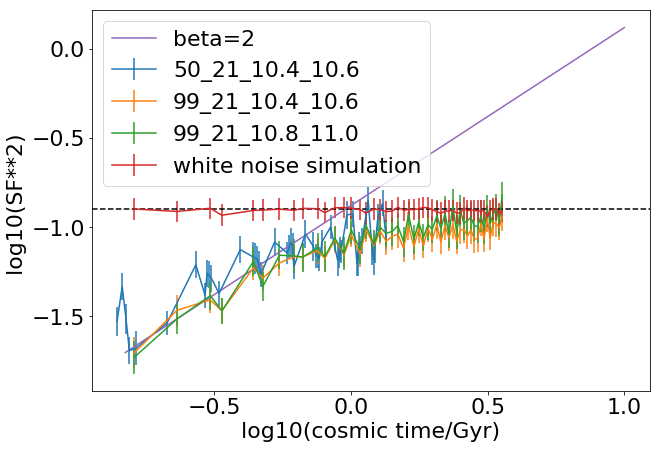

In [560]:
plt.rcParams["figure.figsize"] = (10,7)
plt.errorbar(SF2evo1[:,0],SF2evo1[:,1],yerr=SF2evo1[:,2],label='50_21_10.4_10.6')
plt.errorbar(SF2evo2[:,0],SF2evo2[:,1],yerr=SF2evo2[:,2],label='99_21_10.4_10.6')
plt.errorbar(SF2evo3[:,0],SF2evo3[:,1],yerr=SF2evo3[:,2],label='99_21_10.8_11.0')
plt.errorbar(SF2evo_sim[:,0],SF2evo_sim[:,1],yerr=SF2evo_sim[:,2],label='white noise simulation')
plt.plot(np.log10(np.linspace(0.15,10,100)),-0.88+np.log10(np.linspace(0.15,10,100)),label='beta=2')
plt.xlabel('log10(cosmic time/Gyr)')
plt.ylabel('log10(SF**2) ')
plt.legend()
plt.axhline(-1.2+np.log10(2), linestyle='--', color='k')